In [28]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#import altair as alt
# need to 'pip install vega' before using renderer
#alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA,TruncatedSVD
import scipy
import os
from joblib import dump, load
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prfs
# test for Selecting The Best Number Of Components For TSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from varname import varname
%matplotlib inline
#fix random seed
np.random.seed(1)

In [7]:
TRAINING_FILE = "../keyword.csv"
TEST_FILE = "../key_word_test.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
print(df_train.isnull().sum())
df_train.head(5)

Unnamed: 0         0
article_number     0
article_words      0
topic              0
IR_binary          0
key_word_10       62
key_word_20       18
key_word_50        0
key_word_100       0
dtype: int64


,Unnamed: 0,article_number,article_words,topic,IR_binary,key_word_10,key_word_20,key_word_50,key_word_100
0,0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS,False,"stock,rate,defend,bank,bank,bank,bank,bank,dol...","cent,cent,cent,stock,rate,end,won,won,won,won,...","open,cent,cent,cent,stock,rate,end,won,won,won...","open,cent,cent,cent,stock,rate,end,won,won,won..."
1,1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS,False,"day,day,day,bank,year,dollar,dollar,deal,deal,...","end,end,day,day,day,point,time,bank,year,dolla...","end,end,day,day,day,point,time,bank,early,year...","end,end,day,day,day,index,point,time,busi,bank..."
2,2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS,False,"world,world,stat,stat,stat,stat,year,releas,re...","world,world,stat,stat,stat,stat,govern,time,ye...","socc,socc,world,world,stat,stat,stat,stat,gove...","socc,socc,world,world,recent,law,stat,stat,sta..."
3,3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS,False,"play,bank,bank,mark,mark,percent,percent,perce...","cent,cent,end,play,unit,bank,bank,mark,mark,pe...","open,cent,cent,end,play,unit,made,bank,bank,tu...","open,cent,cent,end,play,unit,made,bank,bank,ra..."
4,4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT,True,day,"day,time,season,clos","minut,minut,minut,day,friday,friday,race,time,...","minut,minut,minut,day,friday,friday,race,time,..."


In [40]:
# Separate out training sets with different size of keywords in the training set
df_train_10 = pd.DataFrame(df_train,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_train_20 = pd.DataFrame(df_train,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_train_50 = pd.DataFrame(df_train,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_train_100 = pd.DataFrame(df_train,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_train_full = pd.DataFrame(df_train,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_train_all = [df_train_10,df_train_20,df_train_50,df_train_100,df_train_full]

In [41]:
# Separate out training sets with different size of keywords in the test set
df_test_10 = pd.DataFrame(df_test,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_test_20 = pd.DataFrame(df_test,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_test_50 = pd.DataFrame(df_test,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_test_100 = pd.DataFrame(df_test,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_test_full = pd.DataFrame(df_test,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_test_all = [df_test_10,df_test_20,df_test_50,df_test_100,df_test_full]

In [10]:
print(df_test_10.isnull().values.any())

True


 ## Functions

In [36]:
def get_df_name(df):
    return ([x for x in globals() if globals()[x] is df][0])

def get_scores(en_train_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_train_y,pred_y,average='macro')
    accuracy = accuracy_score(en_train_y,pred_y)
    recall = recall_score(en_train_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])
def save_variable(variable,filename):
    file_name = "Models/"+filename+".joblib"
    if not os.path.exists(file_name):
    # Export the model (TFIDF+logistic regressor)
        with open(file_name, "wb") as file:
            dump(variable, file, compress=True)
    else:
        print("Warn: this model already exits...")
        
def retrieve_variable(filename):
    file_name = "Models/"+filename+".joblib"
    return(load(file_name))

def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    #le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
def grid_search(vectorizer,model,train_x,train_y,topics):
    kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
    estimators = [
                ("vectorizer",vectorizer),
                ("model",model)
                  ]
    pipe = Pipeline(estimators)

    param_grid = {
                "vectorizer__min_df":[i for i in range(1,6)],
                "model__alpha":[0.001,0.01,0.1,1],
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]],
                "model__fit_prior":[True,False]
                 }
    grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)
    grid_result=grid_search.fit(train_x, train_y)
    return (grid_result.best_estimator_,grid_result.best_score_)
    
def get_model(df_train):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    new_train_x = vectorizer.inverse_transform(smo_x)
    new_train_x = pd.Series([','.join(item) for item in new_train_x])
    # Start grid search
    count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    if(count_clf_accuracy>=tfidf_clf_accuracy):
        print(f'*************************************************************')
        print(f'Now the training set is {get_df_name(df_train)}, and the model chosen is count_clf_NB')
        print(f'The accuracy is {count_clf_accuracy}')
        return (count_clf_NB,le,encode_mapping)
    else:
        print(f'*************************************************************')
        print(f'Now the training set is {get_df_name(df_train)}, and the model chosen is tfidf_clf_NB')
        print(f'The accuracy is {tfidf_clf_accuracy}')
        return (tfidf_clf_NB,le,encode_mapping)
    
def test_model(df_test,model,le,encode_mapping):
    test_x = df_test.key_word
    test_y = df_test.topic
    topics = list(set(df_test['topic']))
    en_test_y = le.transform(test_y)
    y_pred = model.predict(test_x)
    get_scores(en_test_y,y_pred,type(model).__name__)
    print(encode_mapping)
    print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")
    print("The scores for each topic is:")
    scores_for_topics(df_test,topics,model,le)
    conf_matrix = confusion_matrix(en_test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=le.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: {'+'.join([step for step in clf_NB.named_steps.keys()])}", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()
    

*************************************************************
Now the training set is df_train_10, and the model chosen is count_clf_NB
The accuracy is 0.7212933530903729
----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_20
F1 score for  Pipeline  model is  0.3823428928932277
Accuracy score for  Pipeline  model is  0.398
Recall score for  Pipeline  model is  0.602017061885483 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.67      0.20         3
           1       0.19      0.20      0.19        15
           2       0.28      0.85      0.42        13
           3       0.02      0.50      0.04         2
   

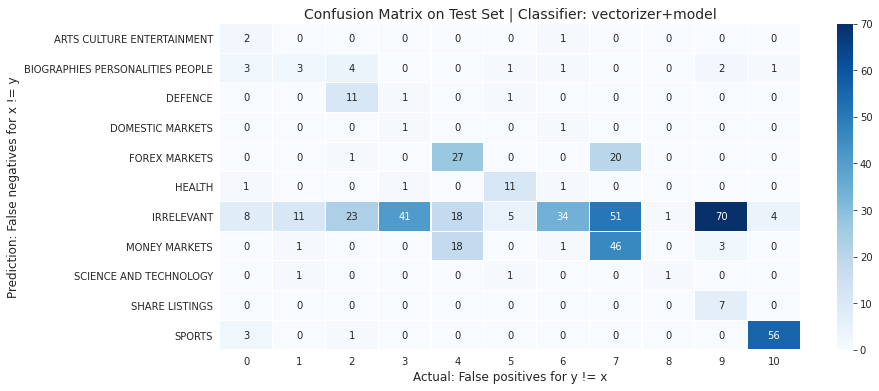

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_50
F1 score for  Pipeline  model is  0.3823428928932277
Accuracy score for  Pipeline  model is  0.398
Recall score for  Pipeline  model is  0.602017061885483 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.67      0.20         3
           1       0.19      0.20      0.19        15
           2       0.28      0.85      0.42        13
           3       0.02      0.50      0.04         2
           4       0.43      0.56      0.49        48
           5       0.58      0.79      0.67        14
           6       0.87      0.13      0.22       266
           7

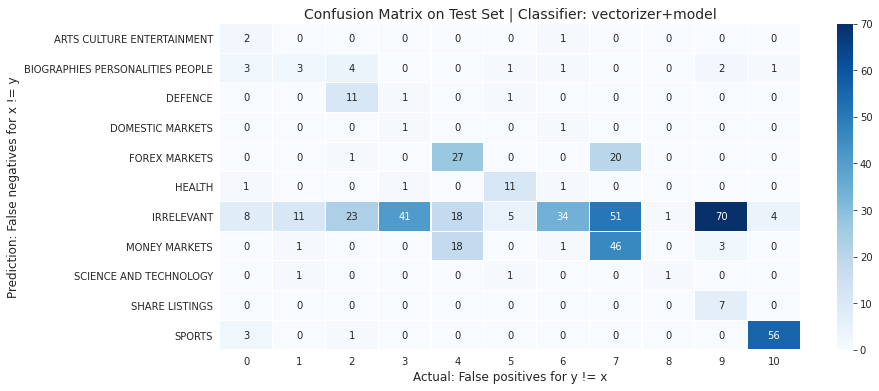

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_100
F1 score for  Pipeline  model is  0.3823428928932277
Accuracy score for  Pipeline  model is  0.398
Recall score for  Pipeline  model is  0.602017061885483 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.67      0.20         3
           1       0.19      0.20      0.19        15
           2       0.28      0.85      0.42        13
           3       0.02      0.50      0.04         2
           4       0.43      0.56      0.49        48
           5       0.58      0.79      0.67        14
           6       0.87      0.13      0.22       266
           

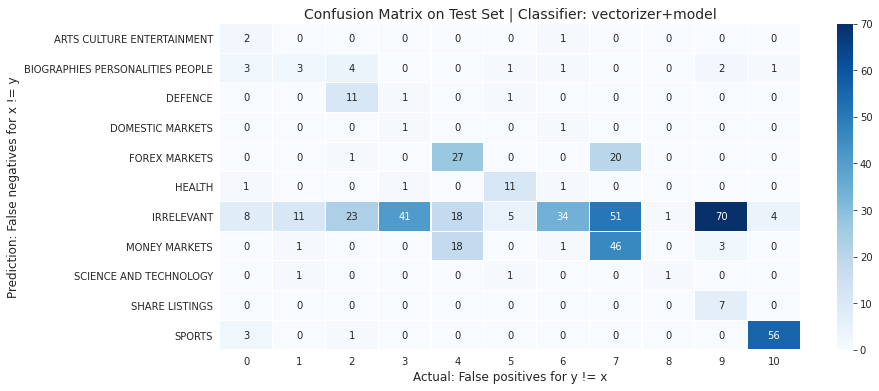

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is test_df
F1 score for  Pipeline  model is  0.3823428928932277
Accuracy score for  Pipeline  model is  0.398
Recall score for  Pipeline  model is  0.602017061885483 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.67      0.20         3
           1       0.19      0.20      0.19        15
           2       0.28      0.85      0.42        13
           3       0.02      0.50      0.04         2
           4       0.43      0.56      0.49        48
           5       0.58      0.79      0.67        14
           6       0.87      0.13      0.22       266
           7   

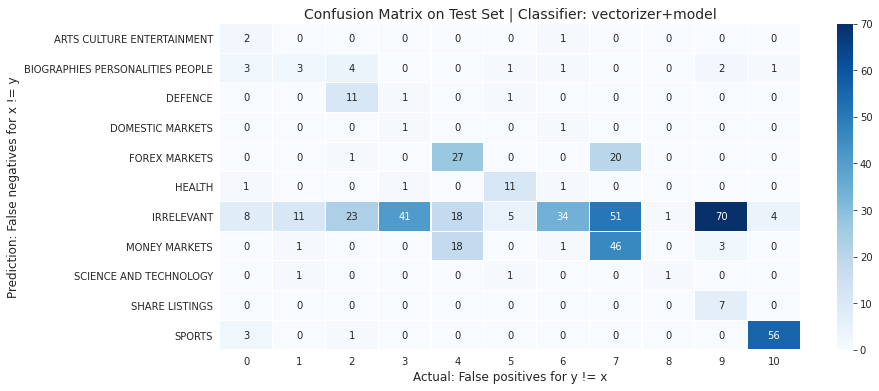

*************************************************************
Now the training set is df_train_20, and the model chosen is count_clf_NB
The accuracy is 0.7715514506864991
----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_20
F1 score for  Pipeline  model is  0.4114358737162307
Accuracy score for  Pipeline  model is  0.436
Recall score for  Pipeline  model is  0.6734490814296307 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.67      0.22         3
           1       0.35      0.40      0.38        15
           2       0.40      0.92      0.56        13
           3       0.04      1.00      0.08         2
  

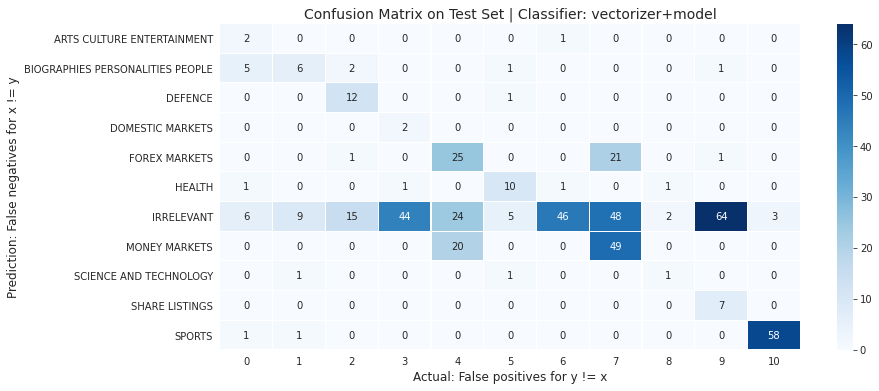

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_50
F1 score for  Pipeline  model is  0.4114358737162307
Accuracy score for  Pipeline  model is  0.436
Recall score for  Pipeline  model is  0.6734490814296307 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.67      0.22         3
           1       0.35      0.40      0.38        15
           2       0.40      0.92      0.56        13
           3       0.04      1.00      0.08         2
           4       0.36      0.52      0.43        48
           5       0.56      0.71      0.63        14
           6       0.96      0.17      0.29       266
           

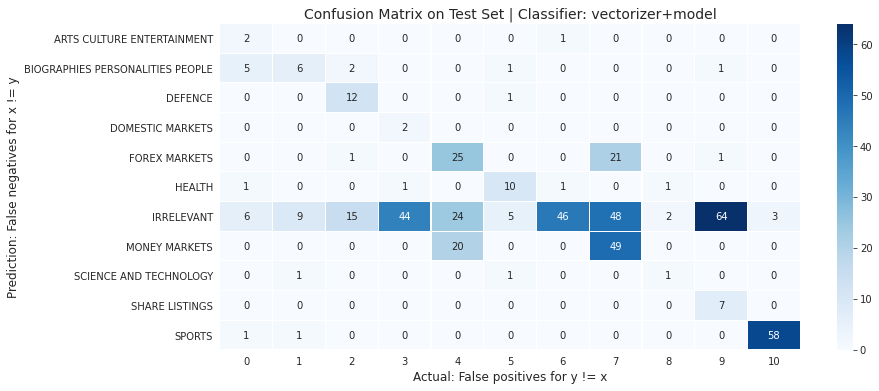

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_100
F1 score for  Pipeline  model is  0.4114358737162307
Accuracy score for  Pipeline  model is  0.436
Recall score for  Pipeline  model is  0.6734490814296307 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.67      0.22         3
           1       0.35      0.40      0.38        15
           2       0.40      0.92      0.56        13
           3       0.04      1.00      0.08         2
           4       0.36      0.52      0.43        48
           5       0.56      0.71      0.63        14
           6       0.96      0.17      0.29       266
          

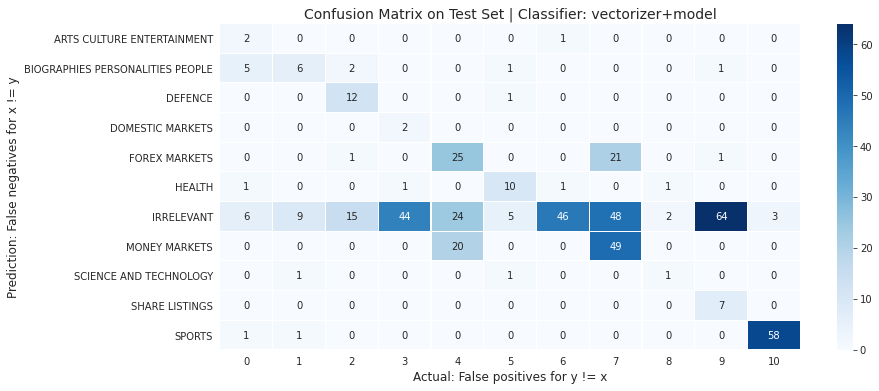

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is test_df
F1 score for  Pipeline  model is  0.4114358737162307
Accuracy score for  Pipeline  model is  0.436
Recall score for  Pipeline  model is  0.6734490814296307 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.67      0.22         3
           1       0.35      0.40      0.38        15
           2       0.40      0.92      0.56        13
           3       0.04      1.00      0.08         2
           4       0.36      0.52      0.43        48
           5       0.56      0.71      0.63        14
           6       0.96      0.17      0.29       266
           7  

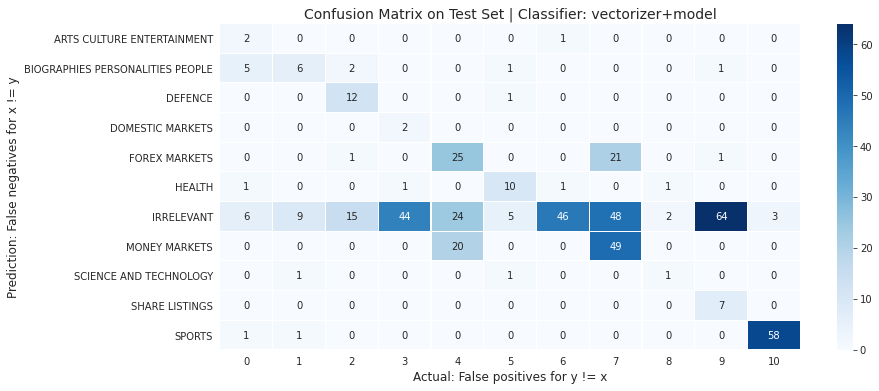

*************************************************************
Now the training set is df_train_50, and the model chosen is count_clf_NB
The accuracy is 0.8204093796398974
----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_20
F1 score for  Pipeline  model is  0.41208607076351983
Accuracy score for  Pipeline  model is  0.436
Recall score for  Pipeline  model is  0.6654245735195392 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.67      0.25         3
           1       0.26      0.33      0.29        15
           2       0.48      0.92      0.63        13
           3       0.04      1.00      0.07         2
 

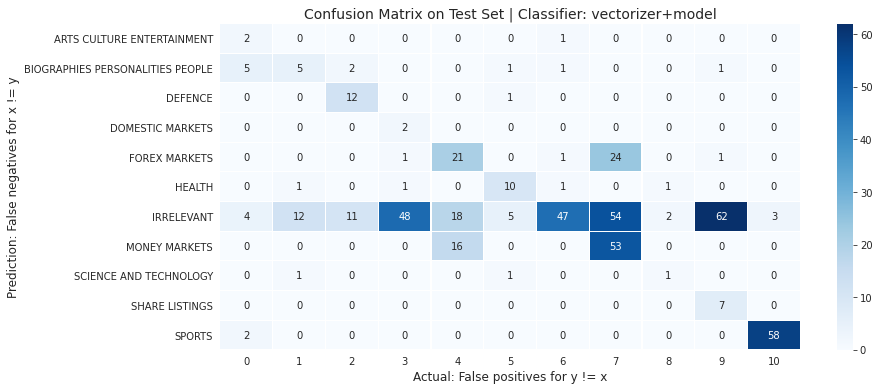

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_50
F1 score for  Pipeline  model is  0.45939726306375694
Accuracy score for  Pipeline  model is  0.486
Recall score for  Pipeline  model is  0.7353492617222593 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.59      0.67      0.62        15
           2       0.32      0.92      0.48        13
           3       0.05      1.00      0.09         2
           4       0.33      0.46      0.39        48
           5       0.55      0.79      0.65        14
           6       0.97      0.26      0.41       266
          

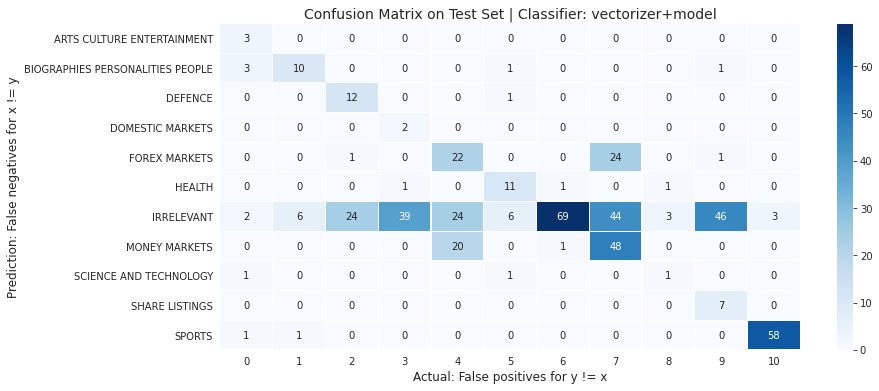

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_100
F1 score for  Pipeline  model is  0.45939726306375694
Accuracy score for  Pipeline  model is  0.486
Recall score for  Pipeline  model is  0.7353492617222593 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.59      0.67      0.62        15
           2       0.32      0.92      0.48        13
           3       0.05      1.00      0.09         2
           4       0.33      0.46      0.39        48
           5       0.55      0.79      0.65        14
           6       0.97      0.26      0.41       266
         

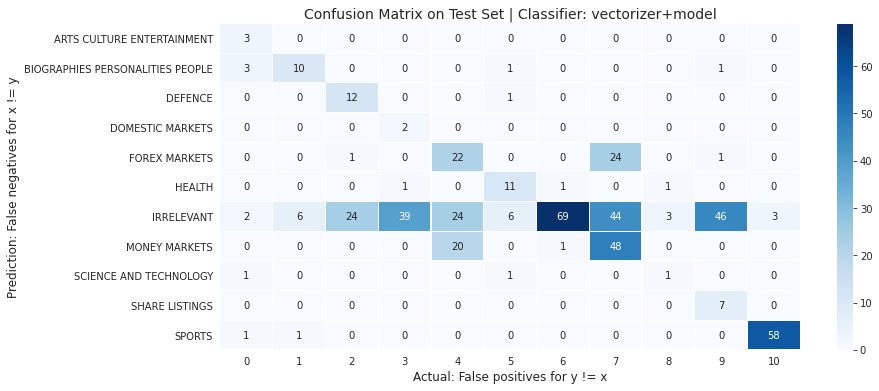

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is test_df
F1 score for  Pipeline  model is  0.45939726306375694
Accuracy score for  Pipeline  model is  0.486
Recall score for  Pipeline  model is  0.7353492617222593 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.59      0.67      0.62        15
           2       0.32      0.92      0.48        13
           3       0.05      1.00      0.09         2
           4       0.33      0.46      0.39        48
           5       0.55      0.79      0.65        14
           6       0.97      0.26      0.41       266
           7 

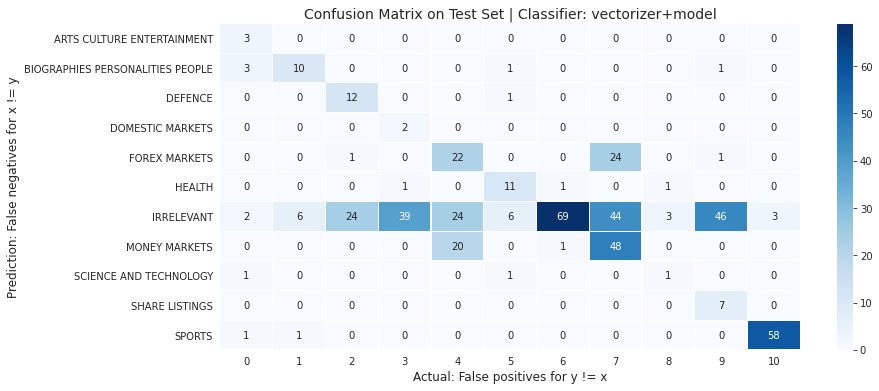

*************************************************************
Now the training set is df_train_100, and the model chosen is tfidf_clf_NB
The accuracy is 0.8355800209277537
----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_20
F1 score for  Pipeline  model is  0.4082877489777397
Accuracy score for  Pipeline  model is  0.426
Recall score for  Pipeline  model is  0.6417584417870459 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.33      0.18         3
           1       0.32      0.40      0.35        15
           2       0.43      0.92      0.59        13
           3       0.04      1.00      0.08         2


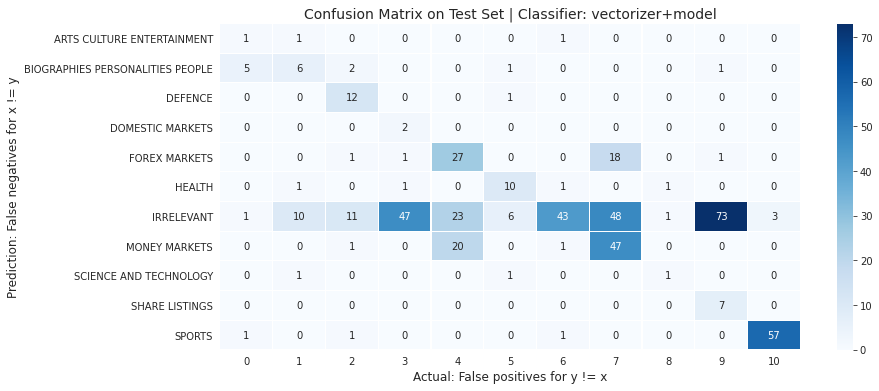

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_50
F1 score for  Pipeline  model is  0.4367893347823545
Accuracy score for  Pipeline  model is  0.48
Recall score for  Pipeline  model is  0.697095648440042 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.67      0.36         3
           1       0.44      0.47      0.45        15
           2       0.31      0.92      0.46        13
           3       0.05      1.00      0.09         2
           4       0.39      0.60      0.47        48
           5       0.52      0.79      0.63        14
           6       0.97      0.24      0.39       266
           7

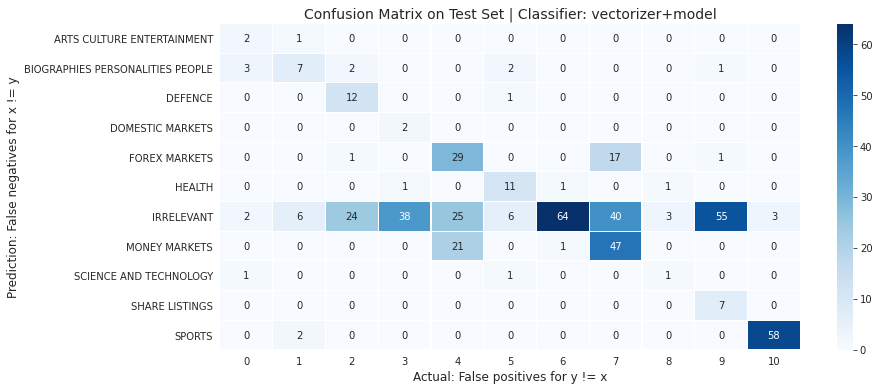

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_100
F1 score for  Pipeline  model is  0.476988168785576
Accuracy score for  Pipeline  model is  0.536
Recall score for  Pipeline  model is  0.6930498372718052 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.33      0.17         3
           1       0.62      0.67      0.65        15
           2       0.32      0.92      0.47        13
           3       0.06      1.00      0.11         2
           4       0.32      0.46      0.38        48
           5       0.55      0.86      0.67        14
           6       0.98      0.35      0.51       266
          

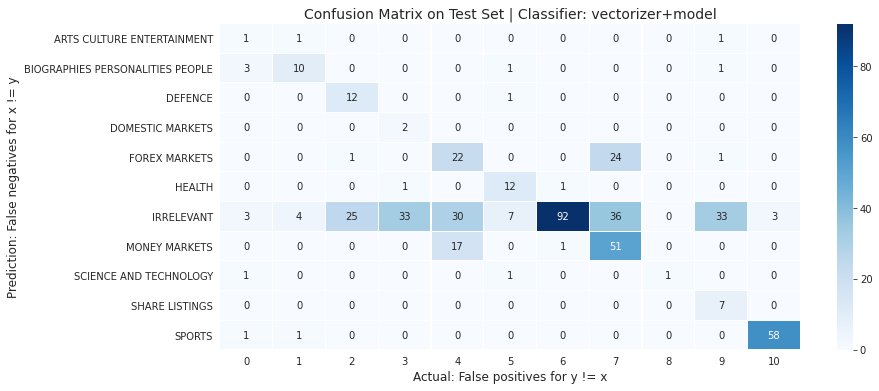

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is test_df
F1 score for  Pipeline  model is  0.476988168785576
Accuracy score for  Pipeline  model is  0.536
Recall score for  Pipeline  model is  0.6930498372718052 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.33      0.17         3
           1       0.62      0.67      0.65        15
           2       0.32      0.92      0.47        13
           3       0.06      1.00      0.11         2
           4       0.32      0.46      0.38        48
           5       0.55      0.86      0.67        14
           6       0.98      0.35      0.51       266
           7  

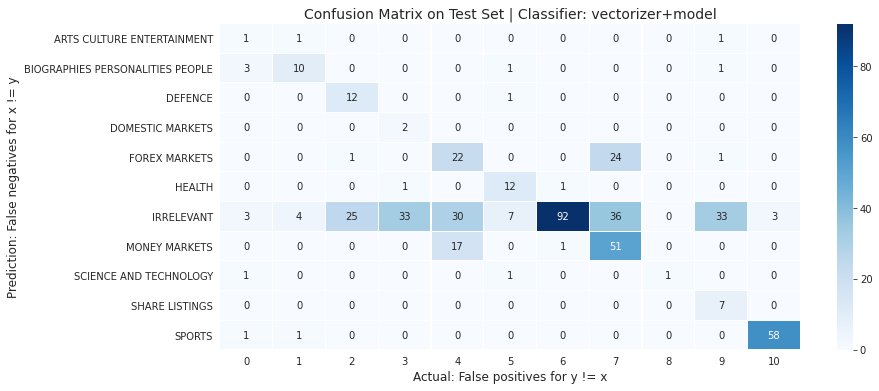

*************************************************************
Now the training set is train_df, and the model chosen is tfidf_clf_NB
The accuracy is 0.9623997900144465
----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is df_test_20
F1 score for  Pipeline  model is  0.3835806267089689
Accuracy score for  Pipeline  model is  0.376
Recall score for  Pipeline  model is  0.6176228805519424 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.50      0.20      0.29        15
           2       0.44      0.92      0.60        13
           3       0.04      1.00      0.08         2
        

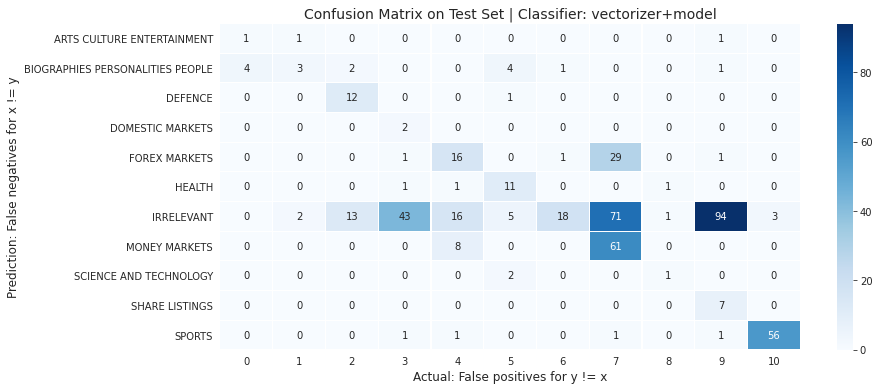

----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is df_test_50
F1 score for  Pipeline  model is  0.3575456353313808
Accuracy score for  Pipeline  model is  0.362
Recall score for  Pipeline  model is  0.5971740502060868 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.38      0.20      0.26        15
           2       0.27      0.85      0.41        13
           3       0.05      1.00      0.09         2
           4       0.33      0.29      0.31        48
           5       0.56      0.71      0.63        14
           6       0.85      0.06      0.12       266
           7  

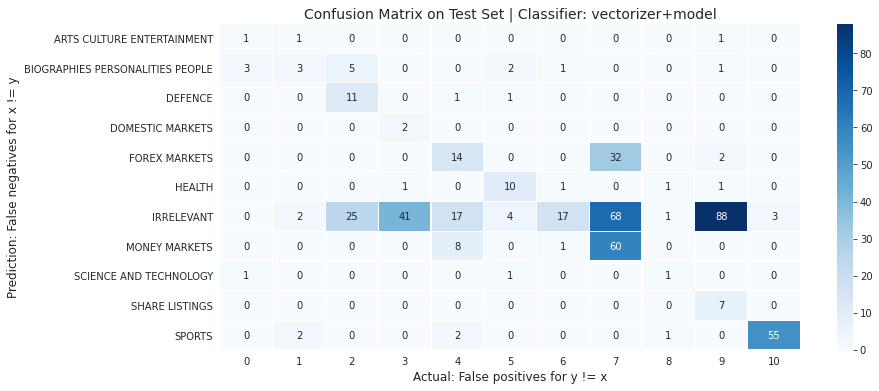

----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is df_test_100
F1 score for  Pipeline  model is  0.40439636005509955
Accuracy score for  Pipeline  model is  0.414
Recall score for  Pipeline  model is  0.6327242646750656 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.56      0.33      0.42        15
           2       0.32      0.85      0.47        13
           3       0.05      1.00      0.10         2
           4       0.39      0.31      0.35        48
           5       0.52      0.86      0.65        14
           6       0.88      0.14      0.24       266
           7

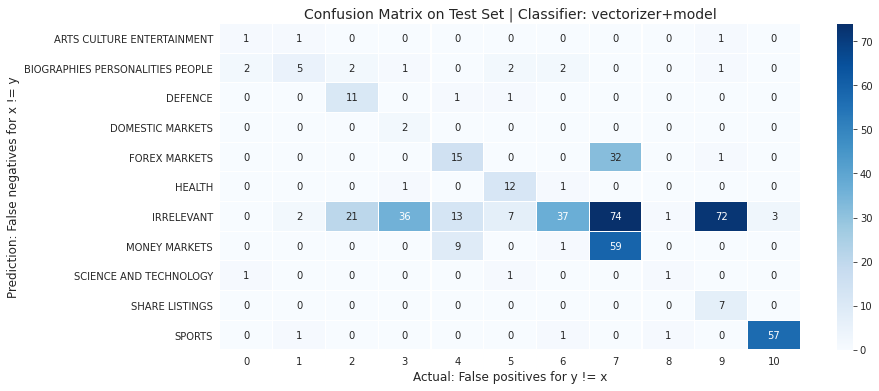

----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is test_df
F1 score for  Pipeline  model is  0.4556854016224356
Accuracy score for  Pipeline  model is  0.724
Recall score for  Pipeline  model is  0.4394210671098543 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       1.00      0.13      0.24        15
           2       0.86      0.46      0.60        13
           3       0.33      0.50      0.40         2
           4       0.36      0.33      0.34        48
           5       0.86      0.43      0.57        14
           6       0.82      0.84      0.83       266
           7     

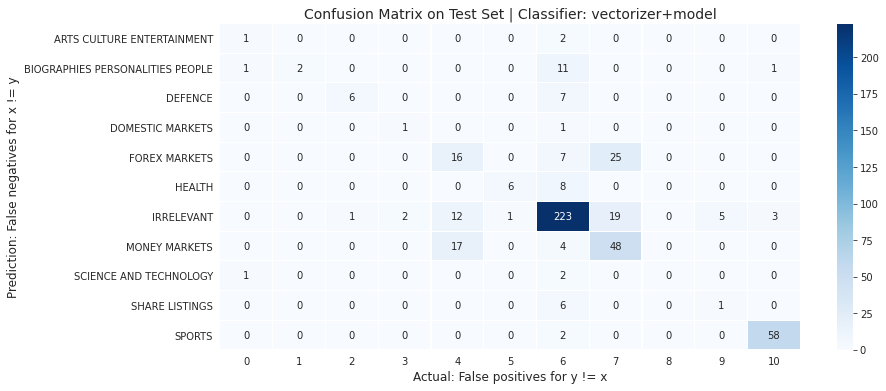

CPU times: user 4min 41s, sys: 2min 50s, total: 7min 31s
Wall time: 2h 35min 7s


In [42]:
%%time
for train_df in df_train_all:
    clf_NB,le,encode_mapping = get_model(train_df)
    for test_df in df_test_all:
        if (test_df.isnull().values.any()):
            continue
        print('----------------------------------------------------------------------')
        print(f'Now, the train_df is {get_df_name(train_df)}, the test_df is {get_df_name(test_df)}')
        test_model(test_df,clf_NB,le,encode_mapping)

In [43]:
# SMOTE with CountVectorizer
def get_model_2(df_train):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = CountVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    new_train_x = vectorizer.inverse_transform(smo_x)
    new_train_x = pd.Series([','.join(item) for item in new_train_x])
    # Start grid search
    count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    if(count_clf_accuracy>=tfidf_clf_accuracy):
        print(f'*************************************************************')
        print(f'Now the training set is {get_df_name(df_train)}, and the model chosen is count_clf_NB')
        print(f'The accuracy is {count_clf_accuracy}')
        return (count_clf_NB,le,encode_mapping)
    else:
        print(f'*************************************************************')
        print(f'Now the training set is {get_df_name(df_train)}, and the model chosen is tfidf_clf_NB')
        print(f'The accuracy is {tfidf_clf_accuracy}')
        return (tfidf_clf_NB,le,encode_mapping)

*************************************************************
Now the training set is df_train_10, and the model chosen is count_clf_NB
The accuracy is 0.7093155030645182
----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_20
F1 score for  Pipeline  model is  0.4292663105706676
Accuracy score for  Pipeline  model is  0.462
Recall score for  Pipeline  model is  0.6387109458047673 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.67      0.18         3
           1       0.30      0.47      0.37        15
           2       0.39      0.85      0.54        13
           3       0.03      0.50      0.06         2
  

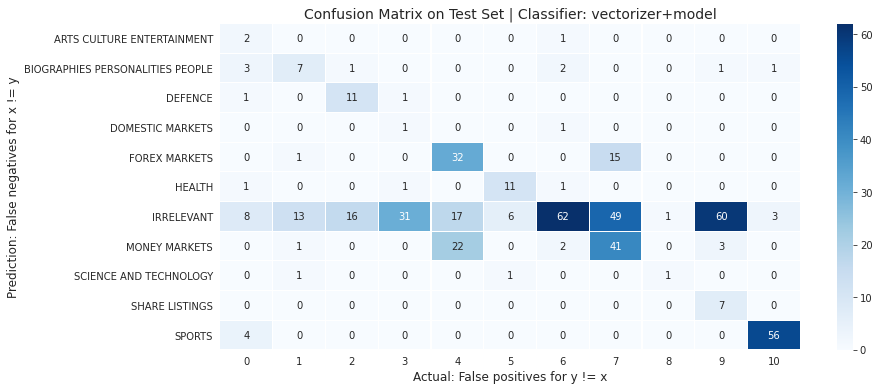

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_50
F1 score for  Pipeline  model is  0.4292663105706676
Accuracy score for  Pipeline  model is  0.462
Recall score for  Pipeline  model is  0.6387109458047673 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.67      0.18         3
           1       0.30      0.47      0.37        15
           2       0.39      0.85      0.54        13
           3       0.03      0.50      0.06         2
           4       0.45      0.67      0.54        48
           5       0.61      0.79      0.69        14
           6       0.90      0.23      0.37       266
           

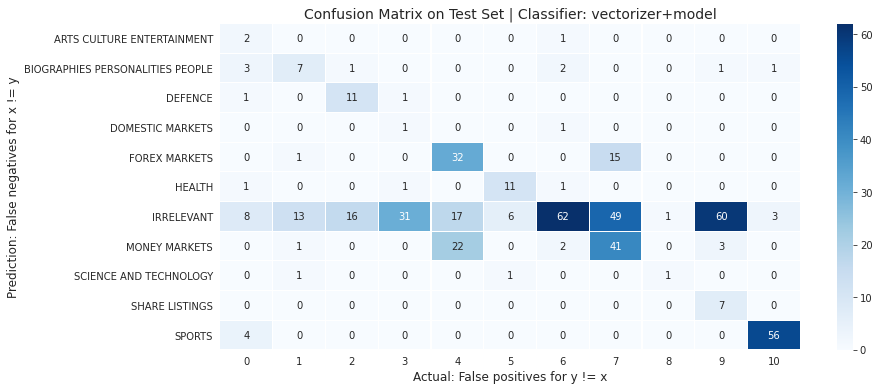

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_100
F1 score for  Pipeline  model is  0.4292663105706676
Accuracy score for  Pipeline  model is  0.462
Recall score for  Pipeline  model is  0.6387109458047673 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.67      0.18         3
           1       0.30      0.47      0.37        15
           2       0.39      0.85      0.54        13
           3       0.03      0.50      0.06         2
           4       0.45      0.67      0.54        48
           5       0.61      0.79      0.69        14
           6       0.90      0.23      0.37       266
          

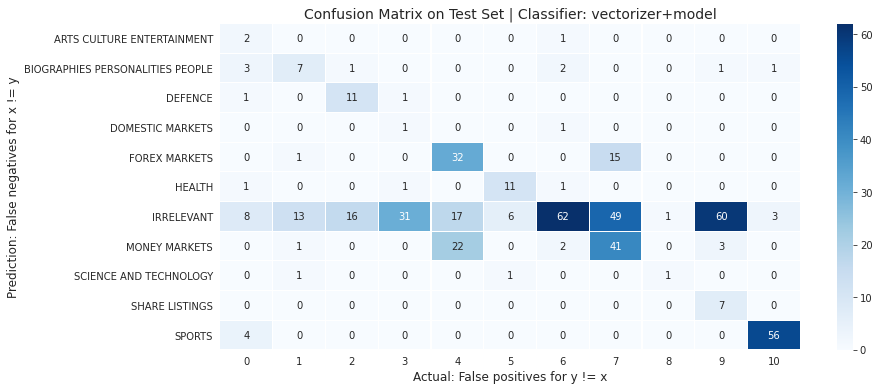

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is test_df
F1 score for  Pipeline  model is  0.4292663105706676
Accuracy score for  Pipeline  model is  0.462
Recall score for  Pipeline  model is  0.6387109458047673 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.67      0.18         3
           1       0.30      0.47      0.37        15
           2       0.39      0.85      0.54        13
           3       0.03      0.50      0.06         2
           4       0.45      0.67      0.54        48
           5       0.61      0.79      0.69        14
           6       0.90      0.23      0.37       266
           7  

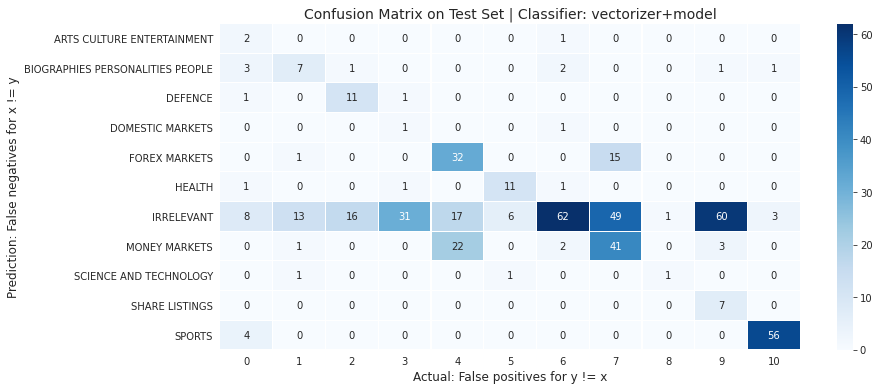

*************************************************************
Now the training set is df_train_20, and the model chosen is tfidf_clf_NB
The accuracy is 0.7613153153032632
----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_20
F1 score for  Pipeline  model is  0.465746454838321
Accuracy score for  Pipeline  model is  0.534
Recall score for  Pipeline  model is  0.691259931906385 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.67      0.25         3
           1       0.26      0.40      0.32        15
           2       0.50      0.85      0.63        13
           3       0.07      1.00      0.13         2
    

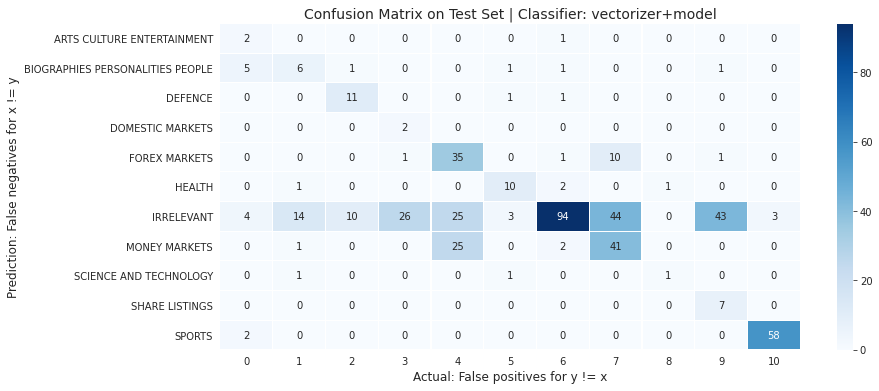

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_50
F1 score for  Pipeline  model is  0.465746454838321
Accuracy score for  Pipeline  model is  0.534
Recall score for  Pipeline  model is  0.691259931906385 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.67      0.25         3
           1       0.26      0.40      0.32        15
           2       0.50      0.85      0.63        13
           3       0.07      1.00      0.13         2
           4       0.41      0.73      0.53        48
           5       0.62      0.71      0.67        14
           6       0.92      0.35      0.51       266
           7 

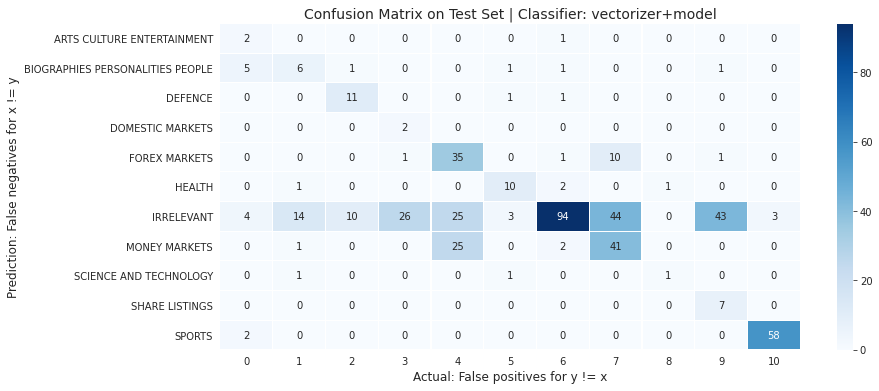

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_100
F1 score for  Pipeline  model is  0.465746454838321
Accuracy score for  Pipeline  model is  0.534
Recall score for  Pipeline  model is  0.691259931906385 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.67      0.25         3
           1       0.26      0.40      0.32        15
           2       0.50      0.85      0.63        13
           3       0.07      1.00      0.13         2
           4       0.41      0.73      0.53        48
           5       0.62      0.71      0.67        14
           6       0.92      0.35      0.51       266
           7

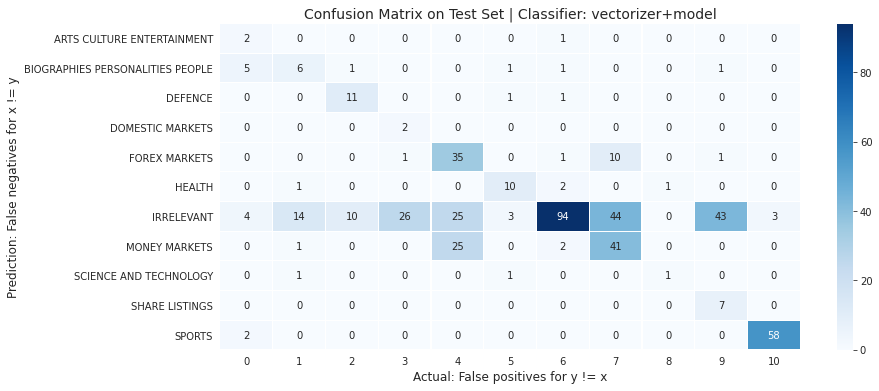

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is test_df
F1 score for  Pipeline  model is  0.465746454838321
Accuracy score for  Pipeline  model is  0.534
Recall score for  Pipeline  model is  0.691259931906385 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.67      0.25         3
           1       0.26      0.40      0.32        15
           2       0.50      0.85      0.63        13
           3       0.07      1.00      0.13         2
           4       0.41      0.73      0.53        48
           5       0.62      0.71      0.67        14
           6       0.92      0.35      0.51       266
           7    

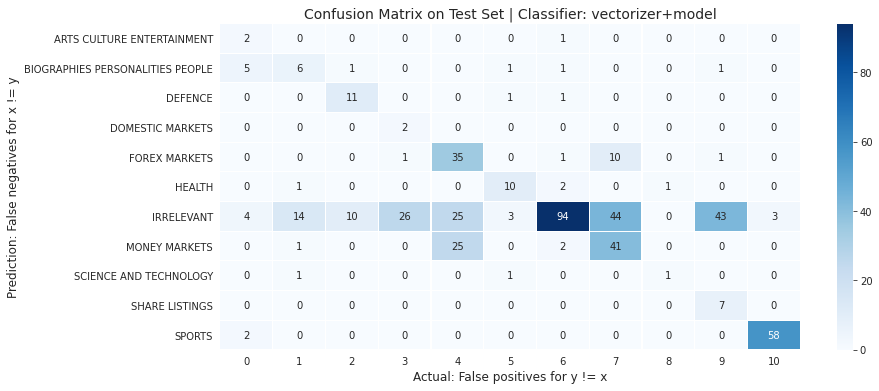

*************************************************************
Now the training set is df_train_50, and the model chosen is tfidf_clf_NB
The accuracy is 0.8105966851016164
----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_20
F1 score for  Pipeline  model is  0.4450420032464713
Accuracy score for  Pipeline  model is  0.466
Recall score for  Pipeline  model is  0.6984048750639139 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.67      0.24         3
           1       0.33      0.53      0.41        15
           2       0.52      0.92      0.67        13
           3       0.05      1.00      0.10         2
  

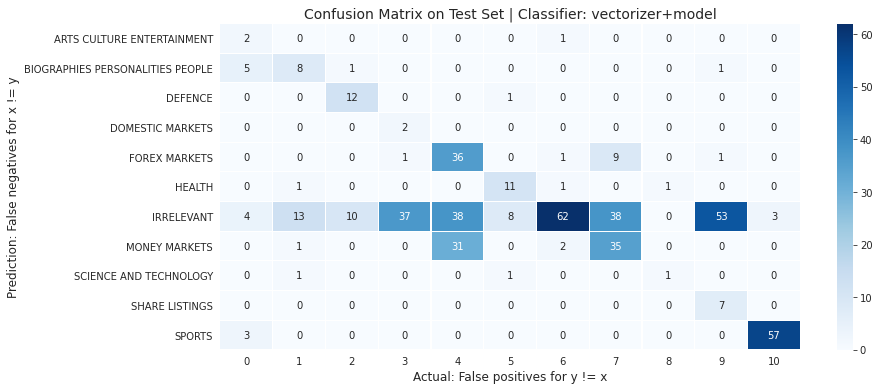

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_50
F1 score for  Pipeline  model is  0.5132226947392878
Accuracy score for  Pipeline  model is  0.586
Recall score for  Pipeline  model is  0.7547151361224587 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.52      0.73      0.61        15
           2       0.34      0.85      0.49        13
           3       0.06      1.00      0.12         2
           4       0.41      0.79      0.54        48
           5       0.61      0.79      0.69        14
           6       0.97      0.42      0.59       266
           

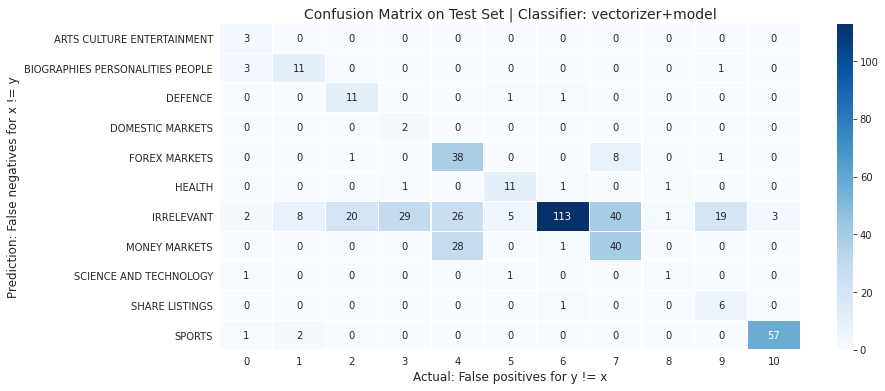

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_100
F1 score for  Pipeline  model is  0.5132226947392878
Accuracy score for  Pipeline  model is  0.586
Recall score for  Pipeline  model is  0.7547151361224587 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.52      0.73      0.61        15
           2       0.34      0.85      0.49        13
           3       0.06      1.00      0.12         2
           4       0.41      0.79      0.54        48
           5       0.61      0.79      0.69        14
           6       0.97      0.42      0.59       266
          

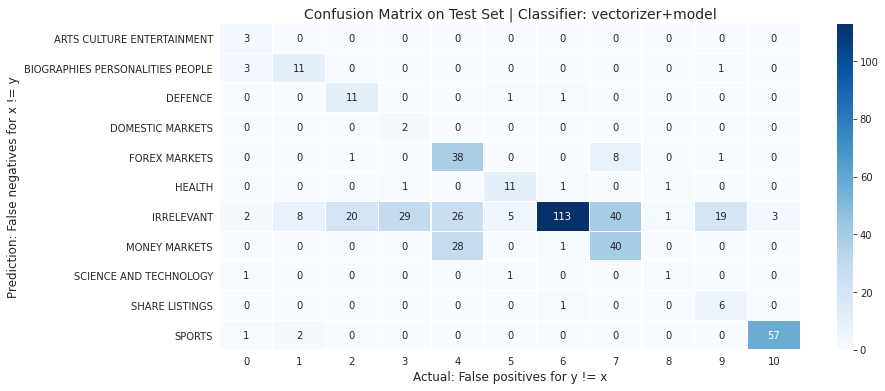

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is test_df
F1 score for  Pipeline  model is  0.5132226947392878
Accuracy score for  Pipeline  model is  0.586
Recall score for  Pipeline  model is  0.7547151361224587 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.52      0.73      0.61        15
           2       0.34      0.85      0.49        13
           3       0.06      1.00      0.12         2
           4       0.41      0.79      0.54        48
           5       0.61      0.79      0.69        14
           6       0.97      0.42      0.59       266
           7  

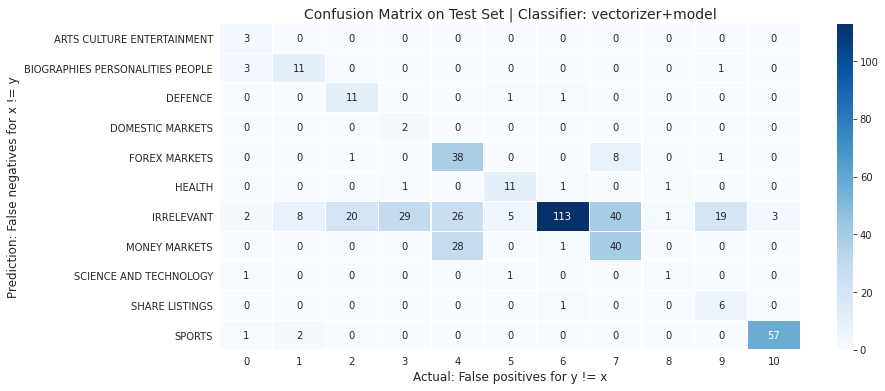

*************************************************************
Now the training set is df_train_100, and the model chosen is count_clf_NB
The accuracy is 0.840438543972326
----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_20
F1 score for  Pipeline  model is  0.42085046740228493
Accuracy score for  Pipeline  model is  0.416
Recall score for  Pipeline  model is  0.6846848041356051 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.67      0.27         3
           1       0.30      0.53      0.38        15
           2       0.46      0.92      0.62        13
           3       0.04      1.00      0.08         2


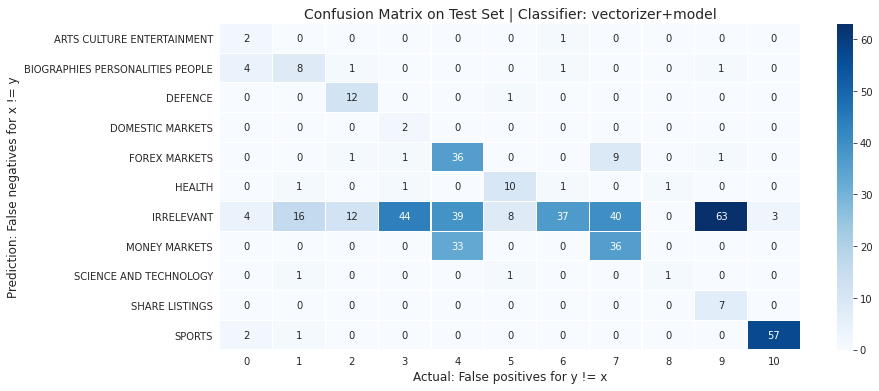

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_50
F1 score for  Pipeline  model is  0.49485225164114177
Accuracy score for  Pipeline  model is  0.528
Recall score for  Pipeline  model is  0.7576468725782225 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.52      0.73      0.61        15
           2       0.31      0.85      0.46        13
           3       0.06      1.00      0.11         2
           4       0.37      0.79      0.51        48
           5       0.61      0.79      0.69        14
           6       0.97      0.31      0.47       266
         

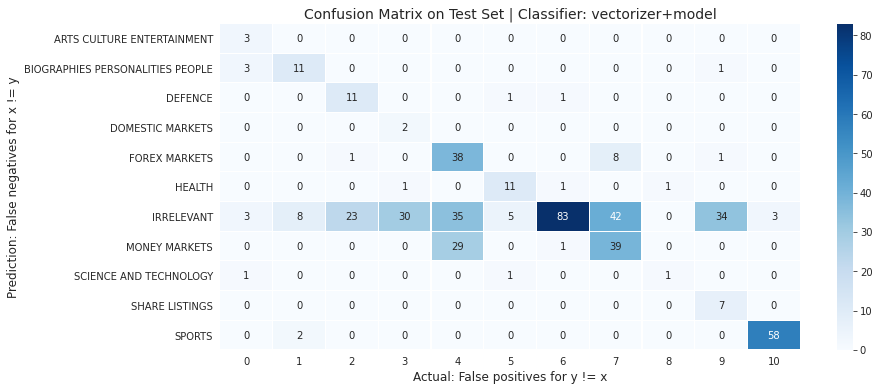

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_100
F1 score for  Pipeline  model is  0.5251245384370083
Accuracy score for  Pipeline  model is  0.61
Recall score for  Pipeline  model is  0.7289097630058727 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.56      0.60      0.58        15
           2       0.35      0.85      0.50        13
           3       0.08      1.00      0.14         2
           4       0.39      0.75      0.51        48
           5       0.58      0.79      0.67        14
           6       0.93      0.48      0.63       266
          

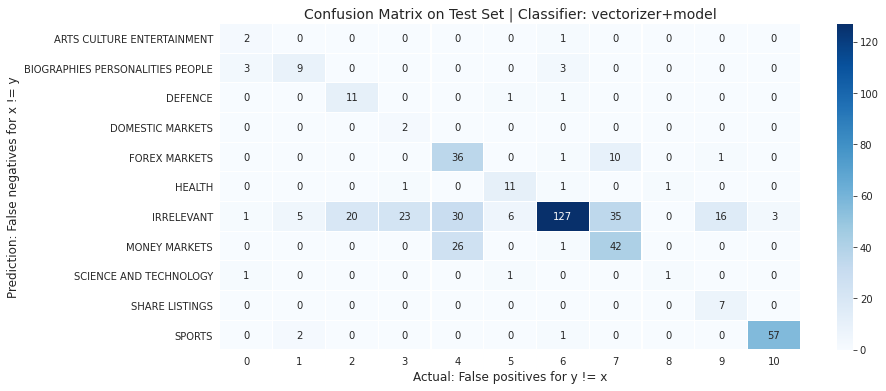

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is test_df
F1 score for  Pipeline  model is  0.5251245384370083
Accuracy score for  Pipeline  model is  0.61
Recall score for  Pipeline  model is  0.7289097630058727 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.56      0.60      0.58        15
           2       0.35      0.85      0.50        13
           3       0.08      1.00      0.14         2
           4       0.39      0.75      0.51        48
           5       0.58      0.79      0.67        14
           6       0.93      0.48      0.63       266
           7  

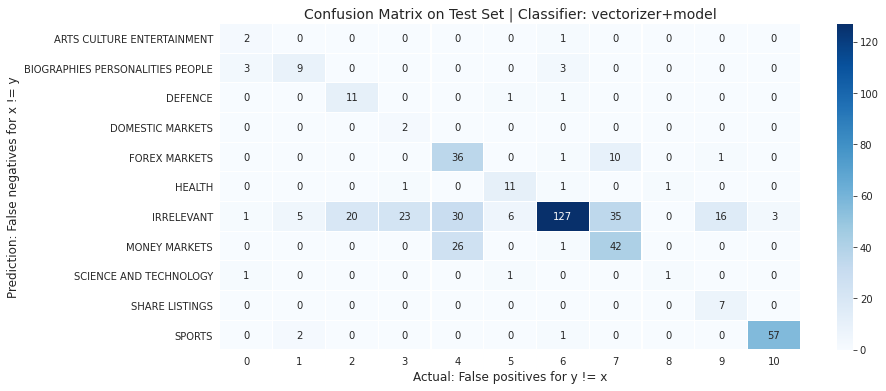

*************************************************************
Now the training set is train_df, and the model chosen is tfidf_clf_NB
The accuracy is 0.9308484280731626
----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is df_test_20
F1 score for  Pipeline  model is  0.38281620753617335
Accuracy score for  Pipeline  model is  0.35
Recall score for  Pipeline  model is  0.6782237404090952 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.50      0.53      0.52        15
           2       0.29      0.92      0.44        13
           3       0.04      1.00      0.07         2
        

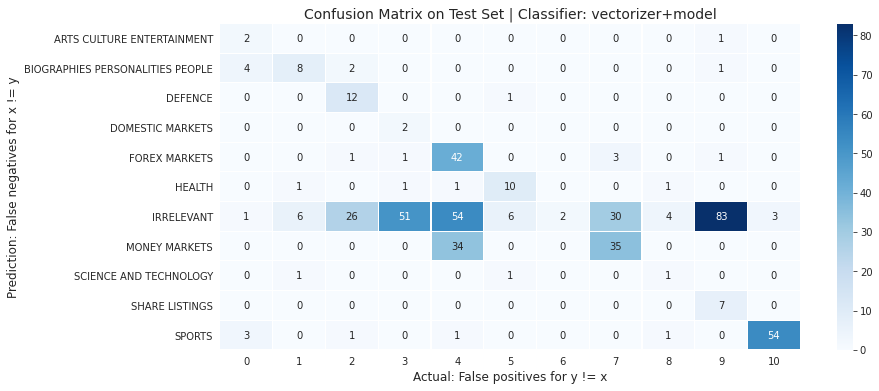

----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is df_test_50
F1 score for  Pipeline  model is  0.41275263275911606
Accuracy score for  Pipeline  model is  0.36
Recall score for  Pipeline  model is  0.7108860533059618 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       0.57      0.53      0.55        15
           2       0.24      0.92      0.38        13
           3       0.04      1.00      0.08         2
           4       0.31      0.85      0.45        48
           5       0.56      0.71      0.63        14
           6       0.83      0.02      0.04       266
           7  

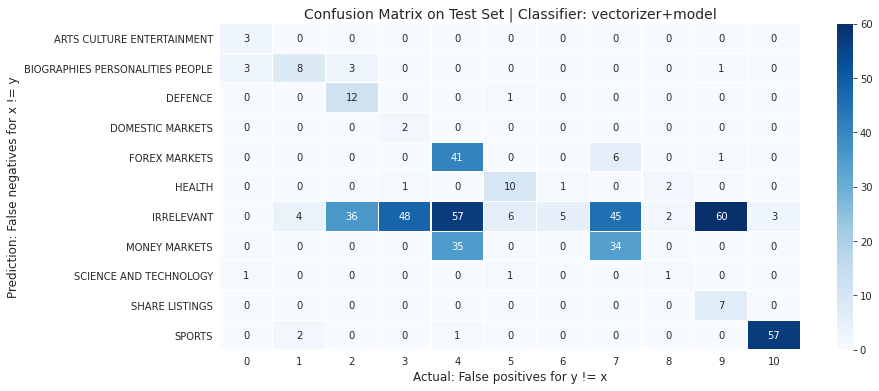

----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is df_test_100
F1 score for  Pipeline  model is  0.43908160786305644
Accuracy score for  Pipeline  model is  0.422
Recall score for  Pipeline  model is  0.6996227170998338 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.62      0.53      0.57        15
           2       0.26      0.92      0.41        13
           3       0.05      1.00      0.09         2
           4       0.32      0.85      0.46        48
           5       0.58      0.79      0.67        14
           6       0.92      0.13      0.22       266
           7

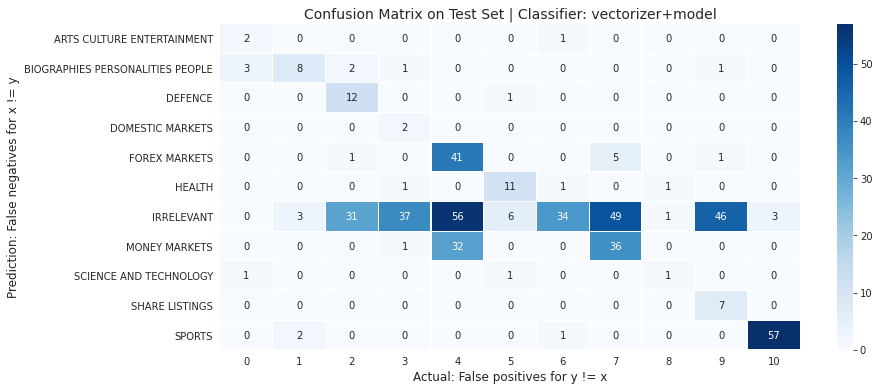

----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is test_df
F1 score for  Pipeline  model is  0.5812766414258494
Accuracy score for  Pipeline  model is  0.724
Recall score for  Pipeline  model is  0.6403599737409805 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.83      0.33      0.48        15
           2       0.56      0.77      0.65        13
           3       0.11      0.50      0.18         2
           4       0.41      0.69      0.52        48
           5       0.76      0.93      0.84        14
           6       0.91      0.72      0.81       266
           7     

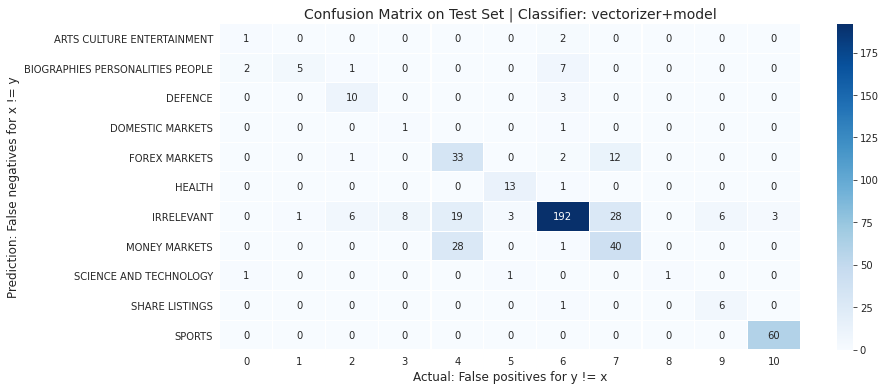

CPU times: user 3min 3s, sys: 10.3 s, total: 3min 13s
Wall time: 51min 4s


In [48]:
%%time
for train_df in df_train_all:
    clf_NB,le,encode_mapping = get_model_2(train_df)
    for test_df in df_test_all:
        if (test_df.isnull().values.any()):
            continue
        print('----------------------------------------------------------------------')
        print(f'Now, the train_df is {get_df_name(train_df)}, the test_df is {get_df_name(test_df)}')
        test_model(test_df,clf_NB,le,encode_mapping)